In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os 
os.chdir("/content/gdrive/My Drive/Colab Notebooks/EVA")

#### Imports

In [3]:
from deep_vision.cutout import get_random_eraser
from deep_vision.gradcam import gradcam

Using TensorFlow backend.


In [4]:
import tensorflow as tf
tf.__version__

'1.15.0-rc3'

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint

#### LR Finder class definition

In [0]:
class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot_lr_loss(self, n_skip_beginning=10, n_skip_end=5, x_scale='log',
                     y_lim=None):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end],
                 self.losses[n_skip_beginning:-n_skip_end])
        plt.ylim(y_lim)
        plt.xscale('log')
        
    def plot_smoothed_lr_loss(self, n_skip_beginning=10, n_skip_end=5, x_scale='log', 
                              y_lim=None):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end],
                 self.smoothed_losses[n_skip_beginning:-n_skip_end])
        plt.ylim(y_lim)
        plt.xscale(x_scale)
        
    def plot_iter_loss(self,n_skip_beginning=10, n_skip_end=5):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[n_skip_beginning:-n_skip_end], 
                 self.losses[n_skip_beginning:-n_skip_end])
        
    def get_derivatives(self, smooth_loss=True, lr_begin=0.001, lr_end=1):
        '''
        returns: tuple of array of derivative of loss w.r.t lr,
                 lr array and loss array in the specified range of lr
        parameters: 
          smooth: whether to use smooth loss
          lr_begin & lr_end: these learning rates specify the range in which to
                             calculate derivative of the loss w.r.t learning rate
        '''
        lr_complete_vector = np.array(self.lrs)
        if lr_begin is not None and lr_end is not None:
            indices = np.where((lr_complete_vector > lr_begin) & (lr_complete_vector < lr_end))
            lr_vector = np.array(lr_complete_vector[indices])
            if smooth_loss:
                loss_vector = np.array(self.smoothed_losses)[indices]
            else:
                loss_vector = np.arrat(self.losses)[indices]
        elif lr_begin is not None and lr_end is None:
            indices = np.where(lr_complete_vector > lr_begin)
            lr_vector = np.array(lr_complete_vector[indices])
            if smooth_loss:
                loss_vector = np.array(self.smoothed_losses)[indices]
            else:
                loss_vector = np.arrat(self.losses)[indices]
        else:
            indices = np.where(lr_complete_vector < lr_end)
            lr_vector = np.array(lr_complete_vector[indices])
            if smooth_loss:
                loss_vector = np.array(self.smoothed_losses)[indices]
            else:
                loss_vector = np.arrat(self.losses)[indices]
        der_vector = np.gradient(lr_vector, loss_vector)
        return der_vector, lr_vector, loss_vector

    def get_best_lr(self, der_vector, lr_vector):
        '''
        returns: learing rate at which loss change is maximum
        parameters:
            1. der_vector: array of the derivatives of loss w.r.t lr
            2. lr_vector: array of lr
        '''
        idx = np.argmax(der_vector)
        return lr_vector[idx]

#### Loading Data

In [7]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 6s 0us/step


In [8]:
print (num_classes)
print (num_train)
print (train_features.shape)

10
50000
(50000, 32, 32, 3)


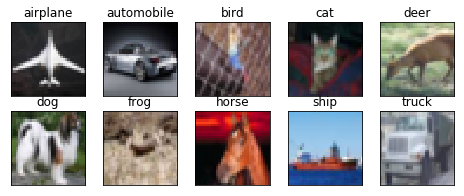

In [9]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
# function to plot loss and accracy curve from model training
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

#### Feature Normalisation

In [13]:
# create generator that centers pixel values
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate the mean on the training dataset
datagen.fit(train_features)

# demonstrate effect on entire training dataset
iterator = datagen.flow(train_features, train_labels, batch_size=len(train_features), shuffle=False)

# get a batch
X_train, y_train = iterator.next()

# pixel stats in the batch
print(X_train.shape, X_train.mean(), X_train.std())
train_features_mean, train_features_std = X_train.mean(axis=(0,1,2)), X_train.std(axis=(0,1,2))

(50000, 32, 32, 3) -1.6605131e-06 1.0000001


In [0]:
iterator1 = datagen.flow(test_features, test_labels, batch_size=len(test_features), shuffle=False)
X_test, y_test = iterator1.next()                        

In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

#### Define the model

In [0]:
# We have removed dropout from the model as we will be adding cutout for regularization
def cifar_model():
    model = Sequential()
    model.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(32, 1, 1))

    model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(32, 1, 1))

    model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(10, 1, 1))
    model.add(AveragePooling2D(pool_size = (4,4)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [19]:
model = cifar_model()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_laun

In [20]:
# Compile the model for lr finder
from keras.optimizers import SGD
sgd = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

#### LR Finder

In [21]:
# using lr finder class defined above, we will find the best learning rate
batch_size=64
lr_finder = LR_Finder(start_lr=1e-5, end_lr=10, step_size=np.ceil(X_train.shape[0]/batch_size))
model.fit(X_train, Y_train, callbacks=[lr_finder], batch_size=batch_size)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
44608/50000 [=========================>....] - ETA: 3s - loss: 2.3947 - acc: 0.3182

From the logs above, it looks like the loss went too high that model stopped training before completing the entire epoch. This is also visible from graph below where the max lr is around 2.5 

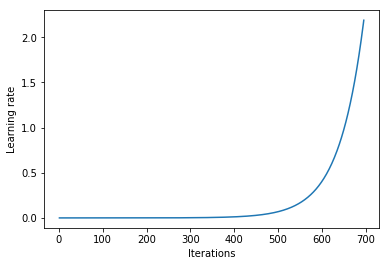

In [22]:
lr_finder.plot_lr()

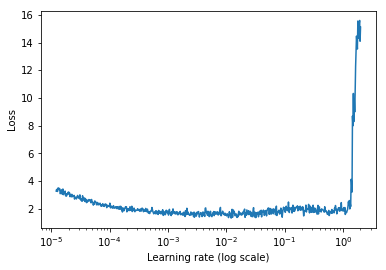

In [23]:
lr_finder.plot_lr_loss()

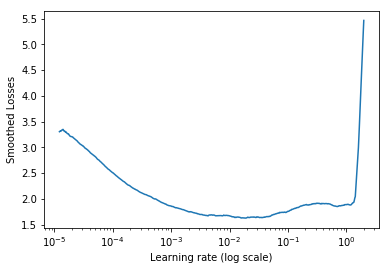

In [24]:
lr_finder.plot_smoothed_lr_loss()

We are interested in the region where loss is falling precipitiously which upon eyeballing looks to be from 0.0001 to 0.01. So, we will look for the best learning rate in the region by finding the lr where  derivative is lowest (as the derivative will be negative)

In [25]:
der_vector, lr_vector, loss_vector = lr_finder.get_derivatives(smooth_loss=True, lr_begin=0.0001, 
                                                               lr_end=0.01)
best_lr = lr_finder.get_best_lr(der_vector*-1, lr_vector)
best_lr

0.009317715865087546

In [27]:
model = cifar_model()
sgd = SGD(lr=best_lr, momentum=0.9)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

def schedule(epoch):
    return round(best_lr*1/(1+0.319*epoch), 10)
lr_scheduler = LearningRateScheduler(schedule)
checkpoint = ModelCheckpoint(filepath='Assg_11_model.{epoch:02d}-{val_acc:.2f}.h5',
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             period=5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `

#### Model Training

In [28]:
datagen = ImageDataGenerator(preprocessing_function=get_random_eraser(v_l=0, v_h=1, 
                                                                      pixel_value=train_features_mean),
                             rotation_range=15, 
                             horizontal_flip=True)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(X_train, Y_train, batch_size = 128), 
                                  steps_per_epoch=X_train.shape[0]/128, epochs= 100,
                                  validation_data = (X_test, Y_test), verbose=0,
                                  callbacks=[lr_scheduler, checkpoint])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))


Epoch 00005: val_acc improved from -inf to 0.74570, saving model to Assg_11_model.05-0.75.h5

Epoch 00010: val_acc improved from 0.74570 to 0.79230, saving model to Assg_11_model.10-0.79.h5

Epoch 00015: val_acc improved from 0.79230 to 0.81600, saving model to Assg_11_model.15-0.82.h5

Epoch 00020: val_acc improved from 0.81600 to 0.82380, saving model to Assg_11_model.20-0.82.h5

Epoch 00025: val_acc improved from 0.82380 to 0.84050, saving model to Assg_11_model.25-0.84.h5

Epoch 00030: val_acc did not improve from 0.84050

Epoch 00035: val_acc improved from 0.84050 to 0.84500, saving model to Assg_11_model.35-0.84.h5

Epoch 00040: val_acc did not improve from 0.84500

Epoch 00045: val_acc did not improve from 0.84500

Epoch 00050: val_acc improved from 0.84500 to 0.84980, saving model to Assg_11_model.50-0.85.h5

Epoch 00055: val_acc did not improve from 0.84980

Epoch 00060: val_acc improved from 0.84980 to 0.85950, saving model to Assg_11_model.60-0.86.h5

Epoch 00065: val_acc d

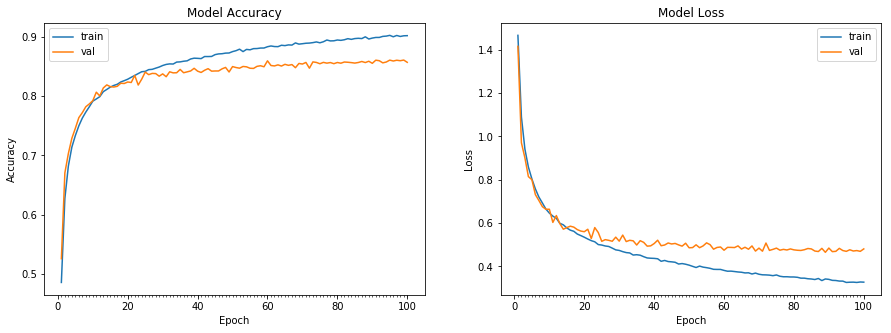

Accuracy on test data is: 85.70


In [29]:
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(X_test, Y_test, model))

In [16]:
# we will load the best model for further analysis
from keras.models import load_model
model = load_model("Assg_11_model.95-0.86.h5")
















Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [17]:
test_predictions =  model.predict(X_test, batch_size=128, verbose=1)
test_predictions_class = np.argmax(test_predictions, axis=1)
test_predictions_class = np.expand_dims(test_predictions_class, axis=1)
print(test_predictions_class.shape, test_labels.shape)
misclassified_images_idx = np.where(test_predictions_class != test_labels)

10000/10000 [==============================] - 5s 507us/step
(10000, 1) (10000, 1)


In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)       

#### Gradcam Activations of the misclassified images

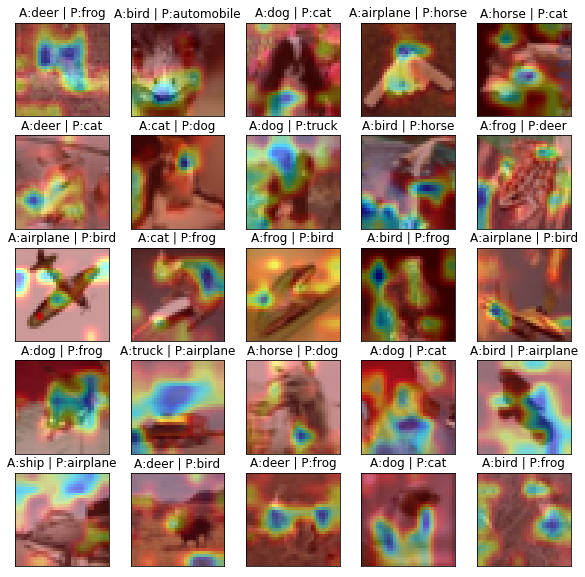

In [19]:
# we will take the second last convolution (conv2d_17) as image of size 4x4 
# is too small for any good representation of the actual. Feature map of
# size 8x8 is quite better to scale the activations back to original image level  
fig = plt.figure(figsize=(10,10))
for i in range(25):
    ax = fig.add_subplot(5, 5, 1 + i, xticks=[], yticks=[])
    idx = misclassified_images_idx[0][i]
    img = test_features[idx, :]
    normalised_img = X_test[idx, :]
    superimposed_img = gradcam(img, normalised_img, model=model, 
                               layer="conv2d_17", n_channels=256) 
    actual_class = class_names[test_labels[idx][0]]
    predicted_class = class_names[test_predictions_class[idx][0]]
    title = f'A:{actual_class} | P:{ predicted_class}'
    ax.set_title(title)
    ax.imshow(superimposed_img)